In [88]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [30]:
def eda_pca(DATA_PATH):
    
    df = pd.read_csv(DATA_PATH)
    X, y = df.drop(["target"], axis = 1), df["target"]
    X_train_og, X_test_og, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    scaler = StandardScaler()
    X_train_scaled, X_test_scaled = scaler.fit_transform(X_train_og), scaler.transform(X_test_og)
    
    pca = PCA(n_components = 2)
    X_train_pca, X_test_pca = pca.fit_transform(X_train_scaled), pca.transform(X_test_scaled)
    
    y = pd.DataFrame(y_train)
    y.reset_index(inplace = True, drop = True)
    df = pd.concat([pd.DataFrame(X_train_pca), y], axis = 1)
    
    return X_train_pca, X_test_pca, y_train, y_test, df, X_train_og, X_test_og

In [31]:
def find_center(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)

    prob = model.predict_proba(X_train) #확률 2차원
    pred = model.predict(X_train) #예측값 1차원

    y_train = pd.DataFrame(y_train) #정답
    y_train.reset_index(inplace = True, drop = True)

    prob_df = pd.DataFrame(prob) #확률 2차원 데이터프레임

    prob_df = pd.concat([prob_df, y_train], axis = 1) #확률 + 정답
    prob_df = pd.concat([prob_df, pd.DataFrame(pred)], axis = 1) #확률 + 정답 + 예측값
    prob_df.columns = ["Prob_Zero", "Prob_One", "target", "Predicted Value"]

    zero_idx = prob_df.sort_values("Prob_Zero", ascending = False)[:10].index
    one_idx = prob_df.sort_values("Prob_One", ascending = False)[:10].index
    
    return list(zero_idx), list(one_idx), prob_df

In [32]:
def make_radius(initial_val, step, patient, df, chk, chk_idx):
    
    flag = True
    r = initial_val
    patient = patient
    
    sub_df = df[df.iloc[:, -1] == chk]
    a, b = df.iloc[chk_idx[0], 0], df.iloc[chk_idx[0], 1]
    
    while flag:
        cnt = 0
        for i in range(len(sub_df)):
            if (sub_df.iloc[i, 0] - a) ** 2 + (sub_df.iloc[i, 1] - b) ** 2 <= r**2:
                cnt += 1
        if cnt > patient: r -= step; flag = False
        else: r += 0.1
    
    return r, a, b

In [33]:
def data_aug(r, a, b):
    
    temp = []
    while True:
        p = np.random.normal(a, scale = 1.0, size = 1)
        q = np.random.normal(b, scale = 1.0, size = 1)
        
        if (p - a)**2 + (q - b)**2 > r**2: continue
        else: temp.append([float(p), float(q)])
        
        if len(temp) == 1000: break
    
    return temp

In [36]:
def sum_data(temp1, temp2):
    
    s1 = pd.concat([pd.DataFrame(temp1), pd.DataFrame([0]*len(temp1))], axis = 1)
    s2 = pd.concat([pd.DataFrame(temp2), pd.DataFrame([1]*len(temp2))], axis = 1)
    
    sub = pd.concat([s1, s2], axis = 0)
    sub.columns = [0, 1, "target"]
    ndf = pd.concat([df, sub], axis = 0)
    ndf.reset_index(inplace = True, drop = True)
    
    return ndf

In [37]:
def scoring(ndf):
    X_new, y_new = ndf.drop(["target"], axis = 1), ndf["target"]
    X_train, y_train
    X_train_old, X_test_old

    m1 = RandomForestClassifier(); m2 = RandomForestClassifier(); m3 = RandomForestClassifier()
    m1.fit(X_train, y_train); m2.fit(X_new, y_new); m3.fit(X_train_old, y_train)
    pred1 = m1.predict(X_test); pred2 = m2.predict(X_test); pred3 = m3.predict(X_test_old)

    acc1 = accuracy_score(pred1, y_test); acc2 = accuracy_score(pred2, y_test); acc3 = accuracy_score(pred3, y_test)
    
    return [acc1, acc2, acc3]

In [78]:
for i in data_lst:

    X_train, X_test, y_train, y_test, df, X_train_old, X_test_old = eda_pca("ljh_df" + str(i) + ".csv")
    zero_idx, one_idx, prob_df = find_center(X_train, y_train)
    
    r1, a1, b1 = np.round(make_radius(0.1, 0.1, 3, df, 1, zero_idx), 2)
    r2, a2, b2 = np.round(make_radius(0.1, 0.1, 3, df, 0, one_idx), 2)
    
    temp1 = data_aug(r1, a1, b1)
    temp2 = data_aug(r2, a2, b2)
    ndf = sum_data(temp1, temp2)
    
    acc = scoring(ndf)
    
    if i == a[0]: df1 = pd.DataFrame(acc).T
    else:
        df1 = pd.concat([df1, pd.DataFrame(acc).T], axis = 0)

In [79]:
for i in data_lst2:

    X_train, X_test, y_train, y_test, df, X_train_old, X_test_old = eda_pca("kcy_df" + str(i) + ".csv")
    zero_idx, one_idx, prob_df = find_center(X_train, y_train)
    
    r1, a1, b1 = np.round(make_radius(0.1, 0.1, 3, df, 1, zero_idx), 2)
    r2, a2, b2 = np.round(make_radius(0.1, 0.1, 3, df, 0, one_idx), 2)
    
    temp1 = data_aug(r1, a1, b1)
    temp2 = data_aug(r2, a2, b2)
    ndf = sum_data(temp1, temp2)
    
    acc = scoring(ndf)
    
    if i == b[0]: df2 = pd.DataFrame(acc).T
    else:
        df2 = pd.concat([df2, pd.DataFrame(acc).T], axis = 0)

In [107]:
final_result = pd.concat([df1, df2], axis = 0)
final_result.reset_index(inplace = True, drop = True)
final_result.columns = ["Aug", "afterPCA", "beforePCA"]
final_result["diff"] = final_result["Aug"] - final_result["afterPCA"]

w, l = 0, 0
for i in range(len(final_result)):
    if final_result.loc[i, "diff"] >= 0: w += 1
    else: l += 1
print(w, l)

18 13


(array([ 2.,  1.,  8., 14.,  4.,  1.,  0.,  0.,  0.,  1.]),
 array([-0.02604167, -0.0184375 , -0.01083333, -0.00322917,  0.004375  ,
         0.01197917,  0.01958333,  0.0271875 ,  0.03479167,  0.04239583,
         0.05      ]),
 <BarContainer object of 10 artists>)

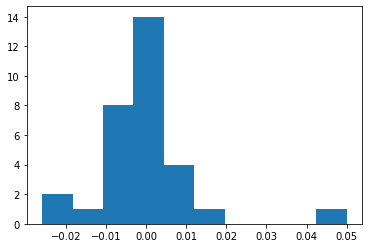

In [108]:
plt.hist(final_result.iloc[:, -1])